# Reseach Project - Coding Results
###  DA 401 - 01: Seminar in Data Analytics
# ------------------------------------------------
#### Name: Minh Nguyen
#### Supervisor: Dr. Sarah Supp
### <center>Regression Model in shaping the Voice Communication Control</center>

### 1. Central Question:
Can the logistic‬ regression model detects whehther the sound files contain the background noise or clean noise?

### 2. Abstract:

Background noise in audio recordings can degrade the sound quality in the VCS. This study investigates using logistic regression to classify audio files as containing background noise or being clean recordings. Signal to noise ratio (SNR) are extracted from the sound files. This feature are used to train a logistic regression model to predict if an audio file contains background noise or not. The performance of the logistic regression model is evaluated on a test set of audio recordings with and without background noise. The results demonstrate the feasibility of using logistic regression for detecting background noise in audio files based on audio features.
    

### 3. Hypothesis:
The hypothesis is that by extracting SNR and training a logistic regression, the model will be able to distinguish between audio with background noise and clean audio without noise. The audio feature is expected to differ systematically between noisy and clean files in ways that the logistic regression model can learn for classification. This hypothesis can be tested by training the model on a dataset of audio files labeled as containing noise or being clean, then evaluating its performance on a held-out test set. The accuracy of the model in detecting background noise in the test set would determine whether the hypothesis is supported.

## 4. Data
###  Noise files:                               
#### - HF_ANALOG                             
#### - VHF_ANALOG                   
                   
### Clean files:
#### - VHF_VOIP
#### - VOIP telephone


### Import required libraries

In [1]:
import librosa
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import scipy.io.wavfile as wav
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load and trim wav files

In [2]:
file_list=["/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/HF_ANALOG.wav",
           "/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VHF_ANALOG.wav",
           "/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VHF_VOIP.wav",
           "/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VOIP telephone.wav"]

def cut_to_duration(audio_file_path, output_file_path, duration_seconds=10):
    """
    Cuts the audio file to the specified duration (in seconds).
    
    Parameters:
    - audio_file_path (str): Path to the input audio file.
    - output_file_path (str): Path to save the truncated audio file.
    - duration_seconds (float, optional): Desired duration in seconds. Default is 10 seconds.
    
    Returns:
    None
    """
    
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)
    
    # Calculate the desired length in samples
    desired_length = sr * duration_seconds
    
    # If the audio is longer than the desired length, truncate it
    if len(y) > desired_length:
        y = y[:desired_length]
    
    # Save the truncated or original audio to the output path
    sf.write(output_file_path, y, sr)

for file in file_list:
    cut_to_duration(file,file)

## Noise files and Clean files

In [3]:
noise_files = ['/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/HF_ANALOG.wav', 
               '/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VHF_ANALOG.wav']
clean_files = ['/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VHF_VOIP.wav',
               '/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VOIP telephone.wav']

## Calculate signal to noise ratio (snr)

In [4]:
def calculate_snr(signal, noise_floor_percentile=10):
    # Estimate noise as the part of the signal that's close to zero
    noise_floor = np.percentile(np.abs(signal), noise_floor_percentile)
    noise_idx = np.abs(signal) < noise_floor
    
    # Calculate signal and noise power
    signal_power = np.mean(signal**2)
    noise_power = np.mean(signal[noise_idx]**2)
    
    # Handle case of zero noise power
    if noise_power == 0:
        return np.inf # Infinite SNR
    else:
    # Compute SNR
        snr = signal_power / noise_power
        return 10 * np.log10(snr)  # Convert to dB

## Calculate signal to noise ratio (snr) over time

In [5]:
def calculate_snr_over_time(file_path,num,frame_length=1024,overlap=512):
    # Read the WAV file
    sample_rate, data = wav.read(file_path)
    
    # Mono-ize if stereo
    if len(data.shape) > 1:
        data = data[:, 0]
        
    # Normalize the signal
    data = data / np.max(np.abs(data))
    
    # Prepare windowing function
    window = np.hanning(frame_length)
    
    # Calculate the number of frames
    step_size = frame_length - overlap
    num_frames = 1 + int((len(data) - frame_length) / step_size)
    
    # Initialize array to hold SNR values
    snr_values = []
    for i in range(num_frames):
        start = i * step_size
        stop = start + frame_length
        frame = data[start:stop] * window
        value = calculate_snr(frame)
        if num == 0:
            snr_values.append(value)
        elif num == 1:
            if value >= 68:
                snr_values.append(value) 
            else: 
                snr_values.append(np.nan)
        
 
    # Time vector for plotting
    time_vector = (np.arange(num_frames) * step_size + frame_length / 2) / sample_rate
    
    return snr_values, time_vector

## Visualize the SNR in two noise files and two clean files

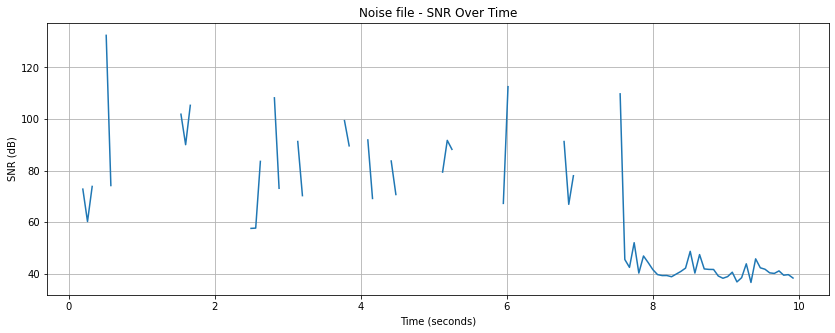

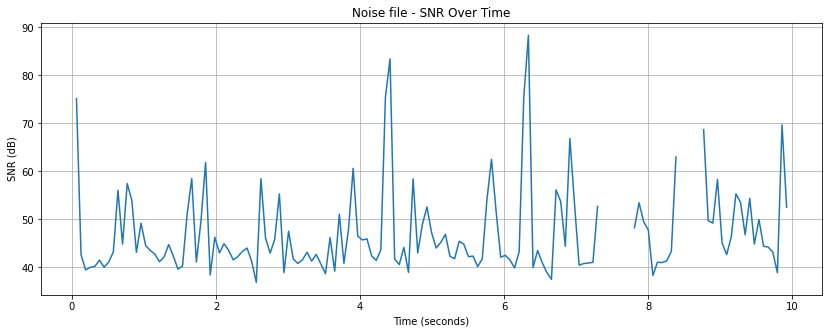

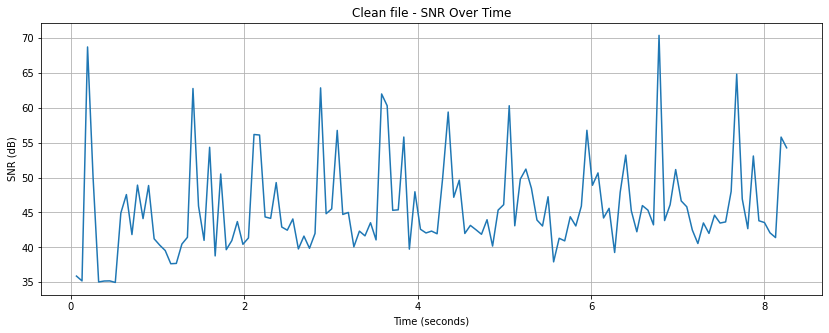

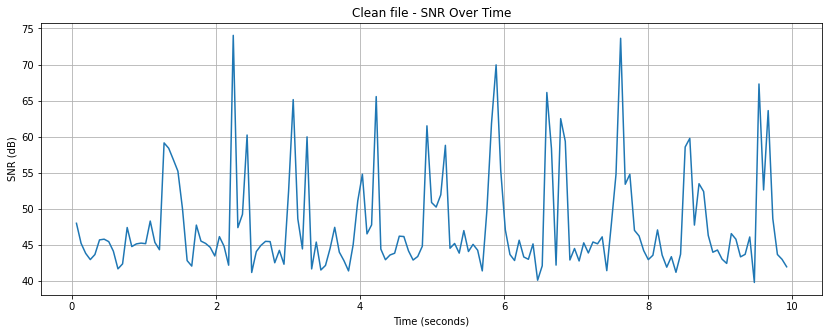

In [6]:
for file in noise_files:
    snr_values, time_vector = calculate_snr_over_time(file,0)
    plt.figure(figsize=(14, 5))
    plt.plot(time_vector, snr_values)
    plt.title("Noise file - SNR Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("SNR (dB)")
    plt.grid(True)
    plt.show()
    

for file in clean_files:
    snr_values, time_vector = calculate_snr_over_time(file,0)
    plt.figure(figsize=(14, 5))
    plt.plot(time_vector, snr_values)
    plt.title("Clean file - SNR Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("SNR (dB)")
    plt.grid(True)
    plt.show()

## Print the dataframe of snr over time (dB) + Label the snr based on clean files and noise files

In [7]:
# Dataframe of snr over time (dB) + Label the snr based on clean files and noise files
def print_dataframe(i,set_type):
    # Variables
    # Training set from HF_ANALOG and VHF_VOIP.wav
    X_train = []  #  Independent variable (snr) 
    Y_train = []  #  Dependent variable (0: clean file , 1: noise file)

    # Testing set from VHF_ANALOG and VOIP telephone
    X_test = []   #  Independent variable (snr)
    Y_test = []   #  Dependent variable (0: clean file , 1: noise file)

    HF_ANALOG_snr = []
    HF_ANALOG = []

    VHF_ANALOG_snr = []
    VHF_ANALOG = []

    VHF_VOIP_snr = []
    VHF_VOIP = []

    VOIP_telephone_snr = []
    VOIP_telephone = []
    
   
    for file in noise_files:
        snr_values, time_vector = calculate_snr_over_time(file,0)
        for time,snr in zip(time_vector, snr_values):
            if np.logical_not(np.isnan(snr)) and np.logical_not(np.isinf(snr)) and snr >= i:
                if file == '/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/HF_ANALOG.wav':
                    HF_ANALOG_snr.append(time)
                    HF_ANALOG_snr.append(snr)
                    X_train.append(snr)
                    Y_train.append(1)
                elif file == '/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VHF_ANALOG.wav':
                    VHF_ANALOG_snr.append(time)
                    VHF_ANALOG_snr.append(snr)
                    X_test.append(snr)
                    Y_test.append(1)
                HF_ANALOG.append(HF_ANALOG_snr)
                VHF_ANALOG.append(VHF_ANALOG_snr)
                HF_ANALOG_snr = []
                VHF_ANALOG_snr = []     


    for file in clean_files:
        snr_values, time_vector = calculate_snr_over_time(file,0)
        for time,snr in zip(time_vector, snr_values):
            if np.logical_not(np.isnan(snr)) and np.logical_not(np.isinf(snr)) and snr >= i:
                if file == '/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VHF_VOIP.wav':
                    VHF_VOIP_snr.append(time)
                    VHF_VOIP_snr.append(snr)
                    X_train.append(snr)
                    Y_train.append(0)
                elif file == '/Users/dangminh0912/Desktop/Year 4 (Sem 1)/DA 401/Dataset/VOIP telephone.wav':
                    VOIP_telephone_snr.append(time)
                    VOIP_telephone_snr.append(snr)
                    X_test.append(snr)
                    Y_test.append(0)
                VHF_VOIP.append(VHF_VOIP_snr)
                VOIP_telephone.append(VOIP_telephone_snr)
                VHF_VOIP_snr = []
                VOIP_telephone_snr = []
    
    
    if set_type == 0:  # Training set
        return X_train, Y_train
    elif set_type == 1:  # Testing set
        return X_test, Y_test
    elif set_type == "HF_ANALOG":
        return pd.DataFrame(HF_ANALOG,columns=['Time','SNR'])
    elif set_type == "VHF_ANALOG":
        return pd.DataFrame(VHF_ANALOG,columns=['Time','SNR'])
    elif set_type == "VHF_VOIP":
        return pd.DataFrame(VHF_VOIP,columns=['Time','SNR'])
    elif set_type == "VOIP_telephone":
        return pd.DataFrame(VOIP_telephone,columns=['Time','SNR'])

In [8]:
# Merge the dataframe
file_df = pd.merge(print_dataframe(1,"HF_ANALOG"), print_dataframe(1,"VHF_ANALOG"), left_index=True, right_index=True)
file_df = pd.merge(file_df, print_dataframe(1,"VHF_VOIP"), left_index=True, right_index=True)
file_df = pd.merge(file_df, print_dataframe(1,"VOIP_telephone"),left_index=True, right_index=True)

# Print the dataframe
file_df.columns = ['Time_HF_Analog', 'SNR_HF_Analog', 
                   'Time_VHF_Analog', 'SNR_VHF_Analog',
                   'Time_VHF_VOIP', 'SNR_VHF_VOIP',
                   'Time_VOIP_telephone', 'SNR_VOIP_telephone']
file_df

,Time_HF_Analog,SNR_HF_Analog,Time_VHF_Analog,SNR_VHF_Analog,Time_VHF_VOIP,SNR_VHF_VOIP,Time_VOIP_telephone,SNR_VOIP_telephone
0,0.192,72.804519,NaN,NaN,0.064,35.887608,NaN,NaN
1,0.256,60.230667,NaN,NaN,0.128,35.197079,NaN,NaN
2,0.320,73.845789,NaN,NaN,0.192,68.713071,NaN,NaN
3,0.512,132.450928,NaN,NaN,0.256,49.945469,NaN,NaN
4,0.576,74.198130,NaN,NaN,0.320,35.047006,NaN,NaN
...,...,...,...,...,...,...,...,...
209,NaN,NaN,9.664,44.258582,NaN,NaN,5.184,58.788540
210,NaN,NaN,9.728,43.200669,NaN,NaN,5.248,44.504871
211,NaN,NaN,9.792,38.898683,NaN,NaN,5.312,45.171101
212,NaN,NaN,9.856,69.708937,NaN,NaN,5.376,43.831741


# Logistical Regression Model

In [9]:
# Reshape the array of X and Y
def np_arr(X,Y):
    X = np.array(X)
    X = X.reshape(-1, 1)
    
    Y = np.array(Y)
    Y = Y.reshape(-1, 1)
    return X,Y

### Train the logistic regression model on training set

In [10]:
# Training on 70 different snr to evaluate which model has the best performance
train_list = []
model_df = pd.DataFrame()
model = LogisticRegression()
for i in range(1,71):
    i_list = []
    
    X_train,Y_train = print_dataframe(i,0)                                                                                          
    X_train,Y_train = np_arr(X_train,Y_train)
    model.fit(X_train, Y_train)
    
    i_list.append(i)
    i_list.append(model.score(X_train,Y_train))
    
    train_list.append(i_list)
    model.fit(X_train, Y_train)
model_df = pd.DataFrame(train_list, columns=['I','SNR'])
model_df  

,I,SNR
0,1,0.770000
1,2,0.770000
2,3,0.770000
3,4,0.770000
4,5,0.770000
...,...,...
65,66,0.937500
66,67,0.935484
67,68,0.966667
68,69,0.965517


In [11]:
max_value_index = model_df['SNR'].idxmax()
print("Heighest model score","\n","SNR >=",model_df.loc[max_value_index,'I'],' ',"Score:",model_df['SNR'].max())

Heighest model score 
 SNR >= 68   Score: 0.9666666666666667


### Plot SNR over time for snr >= 68

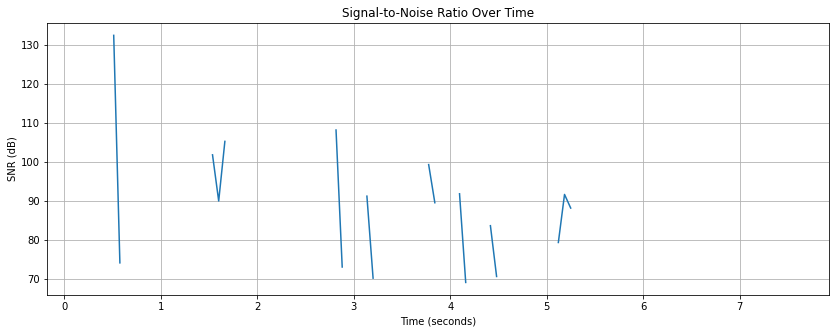

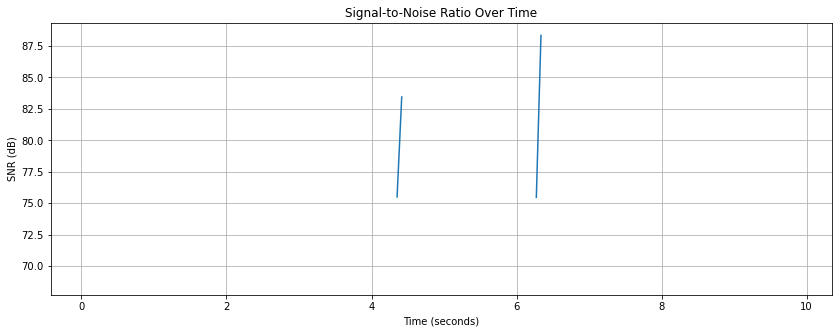

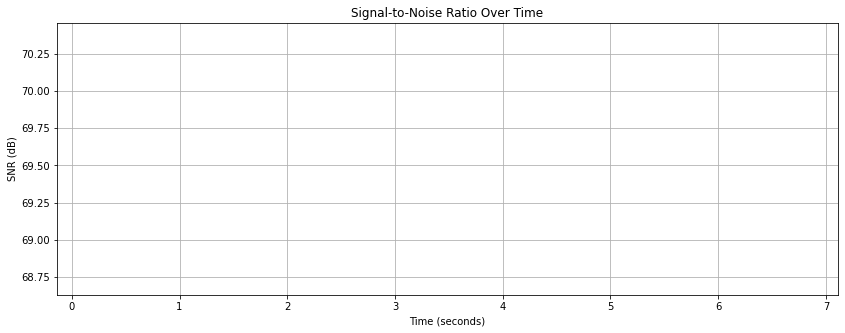

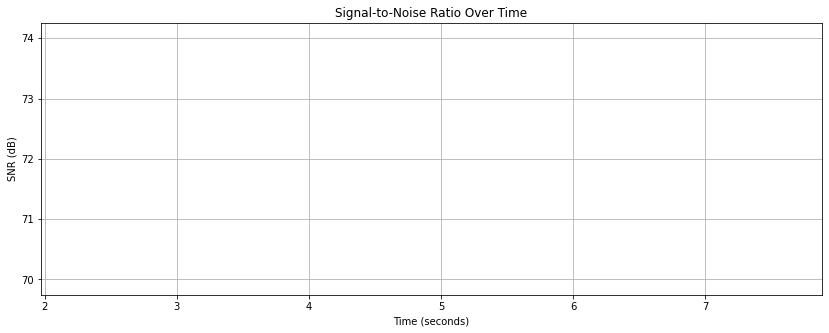

In [12]:
for file in noise_files:
    snr_values, time_vector = calculate_snr_over_time(file,1)
    plt.figure(figsize=(14, 5))
    plt.plot(time_vector, snr_values)
    plt.title("Signal-to-Noise Ratio Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("SNR (dB)")
    plt.grid(True)
    plt.show()
    

for file in clean_files:
    snr_values, time_vector = calculate_snr_over_time(file,1)
    plt.figure(figsize=(14, 5))
    plt.plot(time_vector, snr_values)
    plt.title("Signal-to-Noise Ratio Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("SNR (dB)")
    plt.grid(True)
    plt.show()


### Test the logistic regression model on testing set

In [13]:
# Testing set that contains any snr >= 68
test_list = []
model_df = pd.DataFrame()
model = LogisticRegression()

X_test,Y_test = print_dataframe(68,1)                                                                                          
X_test,Y_test = np_arr(X_test,Y_test)
model.fit(X_test, Y_test)
print("Model score is: ",model.score(X_test,Y_test)) 

Model score is:  0.6


## Sources

https://en.wikipedia.org/wiki/Signal-to-noise_ratio

https://emastered.com/blog/signal-to-noise-ratio

https://play.fallows.ca/wp/radio/ham-radio/signal-noise-ratio-essence-radio/

https://resources.pcb.cadence.com/blog/2020-what-is-signal-to-noise-ratio-and-how-to-calculate-it